# Advanced NN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

data_dir = '/home/mskang/hyeokjong/kaggle/dataset'

# 데이터 확인

In [2]:
Train = pd.read_csv(data_dir + '/Train.csv')
Test = pd.read_csv(data_dir + '/Test.csv')
submission = pd.read_csv(data_dir + '/submission.csv')

In [3]:
X = Train.iloc[:, :-1].values
y = Train.iloc[:, -1].values

In [4]:
X_test = Test.values

# 데이터 분리

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

# 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

# 함수 및 환경 설정

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [8]:
BATCH_SIZE = 30000

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [9]:
for a,b in train_loader:
    input = a
    target = b
    break
print(input.shape, target.shape)

torch.Size([30000, 784]) torch.Size([30000])


In [10]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [11]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [12]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

# Simple_DNN

# 제출

In [13]:

EPOCHS = 150

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    d = 0.5
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 784),
        nn.BatchNorm1d(784),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(784, 784),
        nn.BatchNorm1d(784),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )

    self.linear3 = nn.Sequential(
        nn.Linear(784, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )

    self.linear4 = nn.Sequential(
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )



    self.linear5 = nn.Sequential(
        nn.Linear(512, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
    for m in self.linear4:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)  
    for m in self.linear5:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)

    x = self.linear2(x)

    x = self.linear3(x)

    x = self.linear4(x)
    x = self.linear5(x)


    return x

In [15]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01

In [16]:
result_list = []
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

    result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 2.7839, 	Train Accuracy: 15.04 %, 	Val Loss: 1.6133, 	Val Accuracy: 52.39 % 

[EPOCH: 2], 	Train Loss: 1.6581, 	Train Accuracy: 41.60 %, 	Val Loss: 1.2807, 	Val Accuracy: 63.56 % 

[EPOCH: 3], 	Train Loss: 1.2190, 	Train Accuracy: 56.71 %, 	Val Loss: 1.0201, 	Val Accuracy: 68.02 % 

[EPOCH: 4], 	Train Loss: 1.0056, 	Train Accuracy: 63.72 %, 	Val Loss: 0.8540, 	Val Accuracy: 70.83 % 

[EPOCH: 5], 	Train Loss: 0.8751, 	Train Accuracy: 67.84 %, 	Val Loss: 0.7776, 	Val Accuracy: 73.12 % 

[EPOCH: 6], 	Train Loss: 0.8028, 	Train Accuracy: 70.27 %, 	Val Loss: 0.7333, 	Val Accuracy: 74.75 % 

[EPOCH: 7], 	Train Loss: 0.7570, 	Train Accuracy: 72.10 %, 	Val Loss: 0.6861, 	Val Accuracy: 76.18 % 

[EPOCH: 8], 	Train Loss: 0.7122, 	Train Accuracy: 73.98 %, 	Val Loss: 0.6301, 	Val Accuracy: 77.79 % 

[EPOCH: 9], 	Train Loss: 0.6865, 	Train Accuracy: 75.16 %, 	Val Loss: 0.5783, 	Val Accuracy: 79.61 % 

[EPOCH: 10], 	Train Loss: 0.6573, 	Train Accuracy: 76.08 %, 	Val Loss: 0.

[EPOCH: 80], 	Train Loss: 0.2808, 	Train Accuracy: 89.92 %, 	Val Loss: 0.2896, 	Val Accuracy: 89.86 % 

[EPOCH: 81], 	Train Loss: 0.2837, 	Train Accuracy: 89.70 %, 	Val Loss: 0.2890, 	Val Accuracy: 89.70 % 

[EPOCH: 82], 	Train Loss: 0.2785, 	Train Accuracy: 90.05 %, 	Val Loss: 0.3002, 	Val Accuracy: 89.37 % 

[EPOCH: 83], 	Train Loss: 0.2761, 	Train Accuracy: 90.02 %, 	Val Loss: 0.2931, 	Val Accuracy: 89.82 % 

[EPOCH: 84], 	Train Loss: 0.2774, 	Train Accuracy: 89.91 %, 	Val Loss: 0.2949, 	Val Accuracy: 89.63 % 

[EPOCH: 85], 	Train Loss: 0.2725, 	Train Accuracy: 90.27 %, 	Val Loss: 0.2877, 	Val Accuracy: 89.76 % 

[EPOCH: 86], 	Train Loss: 0.2696, 	Train Accuracy: 90.27 %, 	Val Loss: 0.2897, 	Val Accuracy: 89.82 % 

[EPOCH: 87], 	Train Loss: 0.2725, 	Train Accuracy: 90.25 %, 	Val Loss: 0.2914, 	Val Accuracy: 89.60 % 

[EPOCH: 88], 	Train Loss: 0.2699, 	Train Accuracy: 90.16 %, 	Val Loss: 0.2959, 	Val Accuracy: 89.66 % 

[EPOCH: 89], 	Train Loss: 0.2620, 	Train Accuracy: 90.45 %, 	Val

In [17]:
!nvidia-smi

Tue Mar  8 14:18:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:5E:00.0 Off |                  N/A |
| 28%   40C    P2    41W / 250W |  11915MiB / 12066MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    Off  | 00000000:D9:00.0 Off |                  N/A |
| 41%   

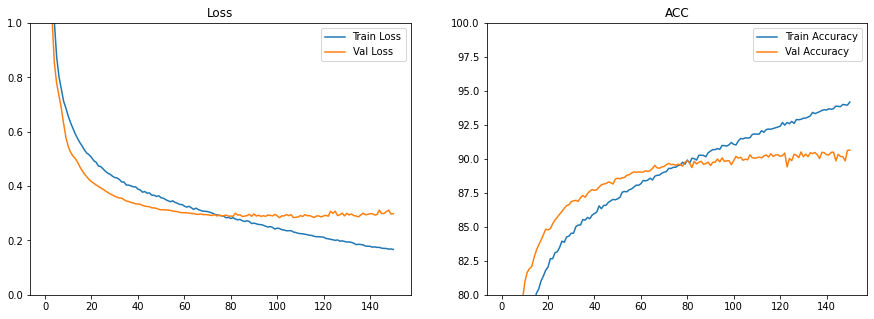

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [22]:

pred_label = pred(model, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + '/BaseLine_Model_0.csv', index = False)

submission.head()


,id,label
0,0,6
1,1,3
2,2,0
3,3,6
4,4,6


In [21]:
type(submission)

pandas.core.frame.DataFrame

##### 